# Titanic

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/nikitaosovskiy/hadnson_ml/blob/main/03-titanic/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="#"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

In [5]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, \
                          recall_score, f1_score, roc_auc_score, roc_curve
from scipy.stats import expon, reciprocal

## Downloading data

In [6]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [7]:
data_path = 'data'
data_folder = os.path.join(data_path, 'titanic.zip')

if not(os.path.exists(data_path)):
    ! mkdir data
    ! cd data && kaggle competitions download -c titanic
    file = zipfile.ZipFile(data_folder)
    file.extractall(data_path)
    ! rm {data_folder}

## Looking for data

In [8]:
def load_data(path):
    file_path = os.path.join('data', path)
    return pd.read_csv(file_path)

start_train = load_data('train.csv')
start_test = load_data('test.csv')
submission_data = load_data('gender_submission.csv')

In [9]:
start_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
start_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [11]:
submission_data.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [12]:
start_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
start_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [14]:
len(start_train['Ticket'].values)

891

In [15]:
len(set(start_train['Cabin'].values))

148

In [16]:
set(start_train['Embarked'].values)

{'C', 'Q', 'S', nan}

## Preparing data

In [17]:
X_train = start_train.drop(['Name', 'Ticket', 'Survived', 'PassengerId', 'Cabin'], axis=1)
y_train = start_train['Survived']

In [18]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,NaN,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


In [19]:
obj_columns = ['Sex', 'Embarked']
num_columns = list(X_train.drop(obj_columns, axis=1).columns)

In [20]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

obj_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

In [21]:
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_columns),
    ('obj', obj_pipeline, obj_columns)
])

X_train_prepared = full_pipeline.fit_transform(X_train)

In [22]:
X_train_prepared.shape

(891, 10)

## Training data

### KNeighbors

In [23]:
some_label = y_train.iloc[:5]
some_data_prepared = X_train_prepared[:5]

In [24]:
kng_clf = KNeighborsClassifier()

kng_clf.fit(X_train_prepared, y_train)

KNeighborsClassifier()

In [25]:
print('Predictions: ', kng_clf.predict(some_data_prepared))
print('Labels: ', list(some_label))

Predictions:  [0 1 1 1 0]
Labels:  [0, 1, 1, 1, 0]


In [26]:
y_train_predictions = cross_val_predict(kng_clf, X_train_prepared, y_train, cv=3)

In [27]:
conf_matrix = confusion_matrix(y_train, y_train_predictions)
conf_matrix

array([[464,  85],
       [104, 238]])

In [28]:
precision_score(y_train, y_train_predictions, average='weighted')

0.7861715749039692

In [29]:
recall_score(y_train, y_train_predictions, average='weighted')

0.7878787878787878

In [30]:
f1_score(y_train, y_train_predictions, average='weighted')

0.7866525596158541

In [31]:
y_train_score_kng = cross_val_predict(kng_clf, X_train_prepared, y_train, cv=3, method='predict_proba')[:, 1]

In [32]:
fpr_kng, tpr_kng, tresholds_kng = roc_curve(y_train, y_train_score_kng)

### SGDC

In [33]:
sgdc_clf = SGDClassifier(random_state=42)

sgdc_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

In [34]:
y_train_predictions = cross_val_predict(sgdc_clf, X_train_prepared, y_train, cv=3)

In [35]:
conf_matrix = confusion_matrix(y_train, y_train_predictions)
conf_matrix

array([[472,  77],
       [132, 210]])

In [36]:
precision_score(y_train, y_train_predictions, average='weighted')

0.7623611335451101

In [37]:
recall_score(y_train, y_train_predictions, average='weighted')

0.7654320987654321

In [38]:
f1_score(y_train, y_train_predictions, average='weighted')

0.7607713830865711

In [39]:
y_train_score_sgdc = cross_val_predict(sgdc_clf, X_train_prepared, y_train, cv=3, method='decision_function')

In [40]:
roc_auc_score(y_train, y_train_score_sgdc)

0.7750455373406193

In [41]:
fpr_sgdc, tpr_sgdc, tresholds_sgdc = roc_curve(y_train, y_train_score_sgdc)

### Random Forest

In [42]:
forest_clf = RandomForestClassifier()

forest_clf.fit(X_train_prepared, y_train)

RandomForestClassifier()

In [43]:
y_train_predictions = cross_val_predict(forest_clf, X_train_prepared, y_train, cv=3)

In [44]:
conf_matrix = confusion_matrix(y_train, y_train_predictions)
conf_matrix

array([[464,  85],
       [100, 242]])

In [45]:
precision_score(y_train, y_train_predictions, average='weighted')

0.7909769830519392

In [46]:
recall_score(y_train, y_train_predictions, average='weighted')

0.792368125701459

In [47]:
f1_score(y_train, y_train_predictions, average='weighted')

0.7914395507254464

In [48]:
y_train_score_forest = cross_val_predict(forest_clf, X_train_prepared, y_train, cv=3, method='predict_proba')[:, 1]

In [49]:
fpr_forest, tpr_forest, tresholds_forest = roc_curve(y_train, y_train_score_forest)

### SVM

In [50]:
svm_clf = SVC()

svm_clf.fit(X_train_prepared, y_train)

SVC()

In [51]:
y_train_predictions = cross_val_predict(svm_clf, X_train_prepared, y_train, cv=3)

In [52]:
conf_matrix = confusion_matrix(y_train, y_train_predictions)
conf_matrix

array([[491,  58],
       [ 96, 246]])

In [53]:
precision_score(y_train, y_train_predictions, average='weighted')

0.8259984857088775

In [54]:
recall_score(y_train, y_train_predictions, average='weighted')

0.8271604938271605

In [55]:
f1_score(y_train, y_train_predictions, average='weighted')

0.8249677805394459

In [56]:
y_train_score_svm = cross_val_predict(svm_clf, X_train_prepared, y_train, cv=3, method='decision_function')

In [57]:
roc_auc_score(y_train, y_train_score_svm)

0.8445605513480118

In [58]:
fpr_svm, tpr_svm, tresholds_svm = roc_curve(y_train, y_train_score_svm)

### Compare

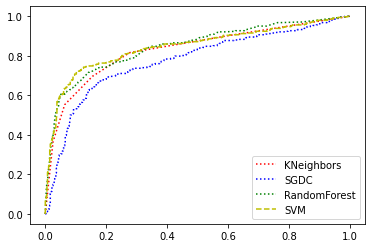

In [59]:
plt.plot(fpr_kng, tpr_kng, "r:", label='KNeighbors')
plt.plot(fpr_sgdc, tpr_sgdc, "b:", label='SGDC')
plt.plot(fpr_forest, tpr_forest, "g:", label='RandomForest')
plt.plot(fpr_svm, tpr_svm, "y--", label='SVM')
plt.legend(loc='lower right')

## Improving model

In [64]:
grid_params = [
    {'C': np.arange(1., 30., 1.), 'gamma': ['auto', 'scale'],
    'kernel': ['rbf', 'linear', 'sigmoid']}
]

grid_search = GridSearchCV(svm_clf, grid_params, cv=3, 
                          scoring='f1_weighted')
grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid=[{'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29.]),
                          'gamma': ['auto', 'scale'],
                          'kernel': ['rbf', 'linear', 'sigmoid']}],
             scoring='f1_weighted')

In [65]:
grid_search.best_estimator_

SVC(C=3.0, gamma='auto')

In [66]:
grid_search.best_score_

0.8280431238427489

## Evaluate model

In [67]:
test_data = start_test.drop(['Name', 'Ticket', 'PassengerId', 'Cabin'], axis=1)

In [68]:
test_data_prepared = full_pipeline.fit_transform(test_data)
best_clf = grid_search.best_estimator_
result_predictions = best_clf.predict(test_data_prepared)

In [69]:
result = pd.DataFrame(np.array([start_test['PassengerId'].values.tolist(), result_predictions]).T, columns=["PassengerId", "Survived"])
result

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [70]:
result.to_csv('result.csv', index=False)